In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.datasets import *
from sklearn.preprocessing import LabelBinarizer #标签二值化
from sklearn.model_selection import train_test_split   #切割数据,交叉验证法

In [15]:
iris = pd.read_csv("Iris.txt",names=['a','b','c','d','class'])
iris['class'][iris['class']=="Iris-setosa"] = 0
iris['class'][iris['class']=="Iris-versicolor"] = 0.5
iris['class'][iris['class']=="Iris-virginica"] = 1
iris_class1 = iris[iris["class"]==0]
iris_class2 = iris[iris["class"]==0.5]
iris_class3 = iris[iris["class"]==1]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


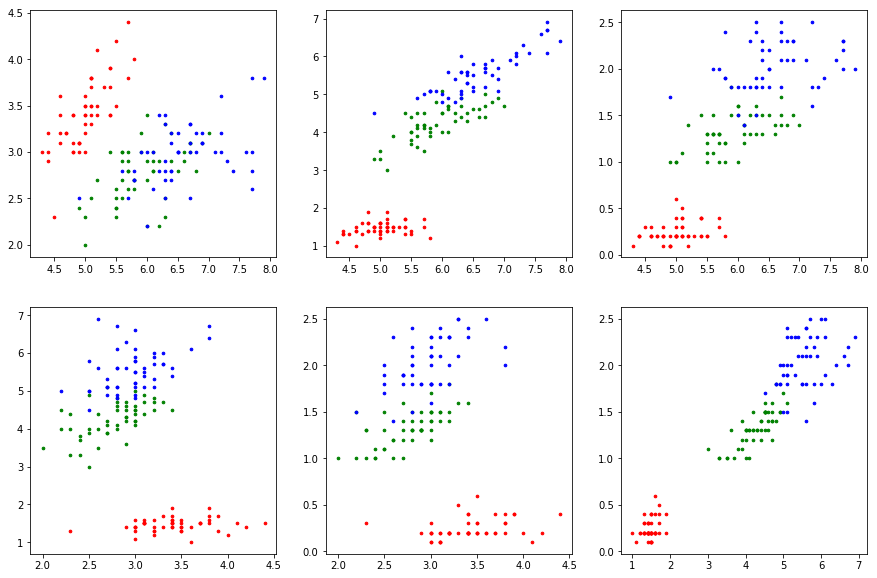

In [16]:
import itertools
plt.figure(figsize=(15,10))
t = 1
for i,j in list(itertools.combinations('abcd',2)):
    plt.subplot(2,3,t)    
    plt.scatter(iris_class1[i],iris_class1[j],7,c='r')
    plt.scatter(iris_class2[i],iris_class2[j],7,c='g')
    plt.scatter(iris_class3[i],iris_class3[j],7,c='b')
    t+=1
plt.show()    

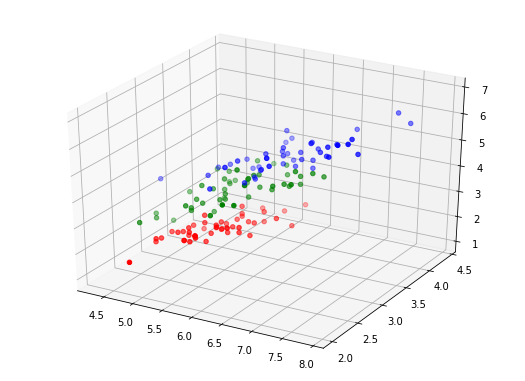

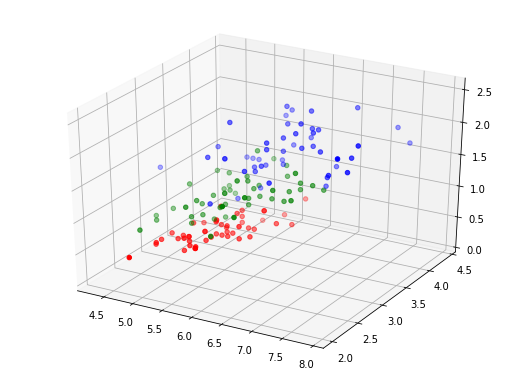

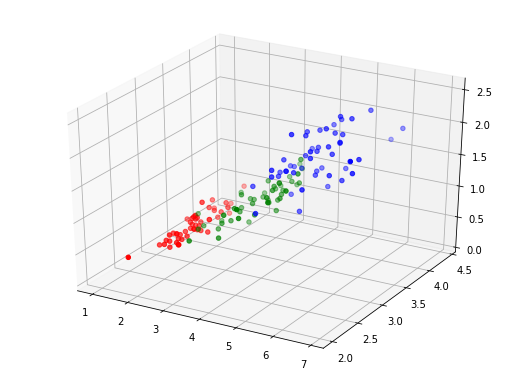

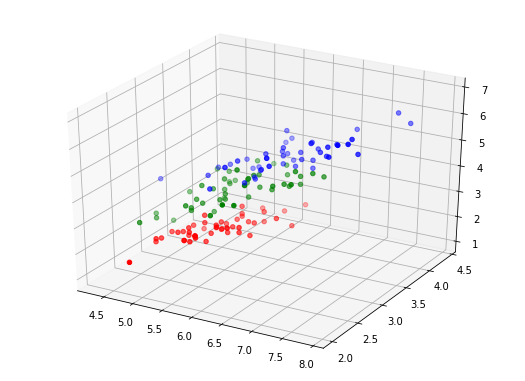

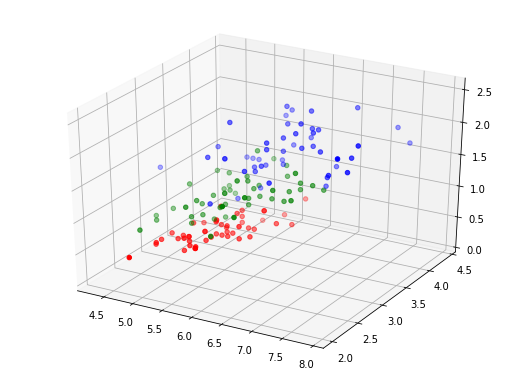

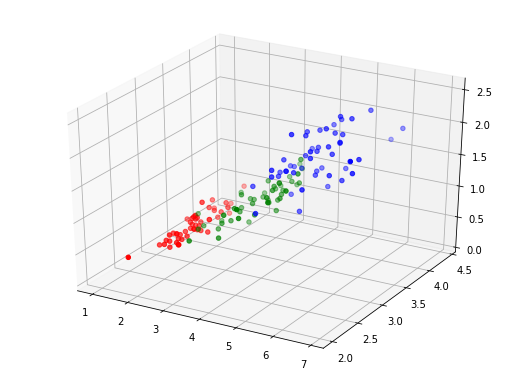

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,5))
ax = Axes3D(fig)
ax.scatter(iris_class1['a'],iris_class1['b'],iris_class1['c'],c='r')
ax.scatter(iris_class2['a'],iris_class2['b'],iris_class2['c'],c='g')
ax.scatter(iris_class3['a'],iris_class3['b'],iris_class3['c'],c='b')
 
fig = plt.figure(figsize=(7,5))
ax = Axes3D(fig)
ax.scatter(iris_class1['a'],iris_class1['b'],iris_class1['d'],c='r')
ax.scatter(iris_class2['a'],iris_class2['b'],iris_class2['d'],c='g')
ax.scatter(iris_class3['a'],iris_class3['b'],iris_class3['d'],c='b')
 
fig = plt.figure(figsize=(7,5))
ax = Axes3D(fig)
ax.scatter(iris_class1['c'],iris_class1['b'],iris_class1['d'],c='r')
ax.scatter(iris_class2['c'],iris_class2['b'],iris_class2['d'],c='g')
ax.scatter(iris_class3['c'],iris_class3['b'],iris_class3['d'],c='b')

plt.show()

In [19]:
temp = np.array(iris)
train_data = np.delete(temp,range(len(temp))[::3],axis=0)
test_data = temp[::3,:]

In [20]:
"""
添加神经网络层的函数
inputs -- 输入内容
in_size -- 输入尺寸
out_size -- 输出尺寸
activation_function --- 激励函数，可以不用输入
"""
def add_layer(inputs,in_size,out_size,activation_function=None):
    W = tf.Variable(tf.zeros([in_size,out_size])+0.01)   #定义，in_size行,out_size列的矩阵,随机矩阵，全为0效果不佳
    b = tf.Variable(tf.zeros([1,out_size])+0.01)              #不建议为0
    Wx_plus_b = tf.matmul(inputs,W) + b                # WX + b
    if activation_function is None:                               #如果有激励函数就激励，否则直接输出
        output = Wx_plus_b
    else:
        output = activation_function(Wx_plus_b)
    return output

In [21]:
X = tf.placeholder(tf.float32,[None,4])
Y = tf.placeholder(tf.float32,[None,1])
 
 
output1 = add_layer(X,4,8,activation_function = tf.nn.sigmoid)
output2 = add_layer(output1,8,3,activation_function = tf.nn.sigmoid)
temp_y = add_layer(output2,3,1,activation_function = tf.nn.sigmoid)
loss = tf.reduce_mean(tf.reduce_sum(tf.square(Y-temp_y),
                                        reduction_indices=[1]))#先求平方，再求和，在求平均
 
train_step = tf.train.AdamOptimizer(0.005).minimize(loss)#通过优化器，以0.1的学习率，减小误差loss

In [22]:
# train_x = iris[['a','b','c']]
# train_y = iris[['class']]
 
#拆分训练集数据集，分为输入和输出
train_x = train_data[:,:4]
train_y = train_data[:,-1:]
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
save_process = []
for i in range(90000):#训练90000次
    sess.run(train_step,feed_dict={X:train_x,Y:train_y})
    if i%300 == 0:#每300次记录损失值（偏差值）
        save_process.append(sess.run(loss,feed_dict={X:train_x,Y:train_y}))

In [23]:
#第前两个数据比较大，踢掉
save_process = np.delete(save_process,[0,1])
plt.plot(range(len(save_process)),save_process)

In [24]:
def compare_numpy(a,b,is_num=False):
    """比较两个维度相同的数组，返回相同数字个数/相似度"""
    num = 0
    for i in range(len(a)):
        if a[i]==b[i]:
            num+=1
    return num if is_num else num/len(a)
	
test_x = test_data[:,:4]
test_y = test_data[:,-1:]
 
result = sess.run(temp_y,feed_dict={X:test_x})
result[result > 0.8] = 1
result[result < 0.2] = 0
result[(result < 0.8) & ( result > 0.2)] = 0.5
 
print("总数:",len(test_data),"     准确个数：",compare_numpy(result,test_y,True),"         精确度：",compare_numpy(result,test_y))

总数: 50      准确个数： 49          精确度： 0.98
